# This is a demonstration notebook for solving inverse AFC plate problem

In [1]:
import jax
import jax.numpy as jnp

from jax_plate.Problem import Problem
from jax_plate.Utils import *
from jax_plate.ParamTransforms import *
from jax_plate.Optimizers import optimize_trust_region, optimize_gd

%matplotlib inline
import matplotlib.pyplot as plt

### Set material parameters

The geometry, location of test point and loading function are defined in a `.edp` file.
In future, meshing independent from `FreeFem++` will be added

In [2]:
# Steel plate
rho = 7920. # [kg/m^3]
E = 198*1e9 # [Pa]
G = 77*1e9
nu = E/(2.*G) - 1.# [1]
h = 1e-3 # [m]
D = E*h**3/(12.*(1. - nu**2))
# this value i don't know
beta = .003 # loss factor, [1]

accelerometer_params = {'radius': 4e-3, 'mass': 1.0e-3}

p = Problem("_strip_shifted.edp", h, rho, accelerometer_params)
get_afc = p.getAFCFunction(isotropic_to_full)
params = jnp.array([D, nu, beta])

Assure that evaluatiion of AFC, loss, derivatives and plotting works.

(DeviceArray(31.6120909, dtype=float64),
 DeviceArray([ -152.84448738,  1565.14098392, -1573.42133188], dtype=float64))

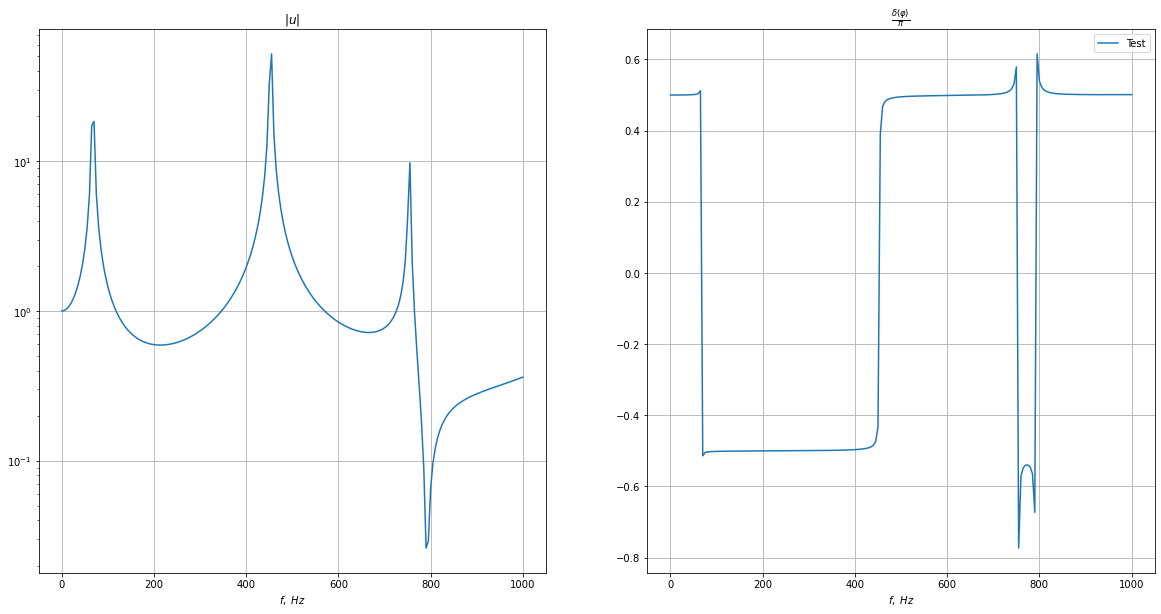

In [3]:
freqs = jnp.linspace(0, 1000, 201, endpoint=True)
afc = get_afc(freqs, params)
fig, axs = plot_afc(freqs, afc, label='Test')
perturbed_params = params*jnp.array([0.9, 1.1, 1.1])
loss_function = p.getMSELossFunction(isotropic_to_full, freqs, afc)
loss_and_grad = jax.value_and_grad(loss_function)
loss_and_grad(perturbed_params)

## Comparing different approaches to accounting for the accelerometer mass

In [4]:
freqs = jnp.linspace(0, 2500, 2501, endpoint=True)
params = jnp.array([D, nu, beta])
accelerometer_params = {'radius': 4e-3, 'mass': 1e-3}

plate_vol = 1e-3 * 2e-2 * 1e-1

rho_adjusted = rho + accelerometer_params['mass']/plate_vol 
# rho if total mass of the accelerometer was distributed around the whole plate

fname = "_strip.edp"

p_w_accel = Problem(fname, h, rho, accelerometer_params)
p_rho_adjusted = Problem(fname, h, rho_adjusted, )
p_no_accel = Problem(fname, h, rho)
bs = 100
afc_w_accel = p_w_accel.getAFCFunction(isotropic_to_full, batch_size=bs)(freqs, params)
afc_no_accel = p_no_accel.getAFCFunction(isotropic_to_full, batch_size=bs)(freqs, params)
afc_rho_adjusted = p_rho_adjusted.getAFCFunction(isotropic_to_full, batch_size=bs)(freqs, params)

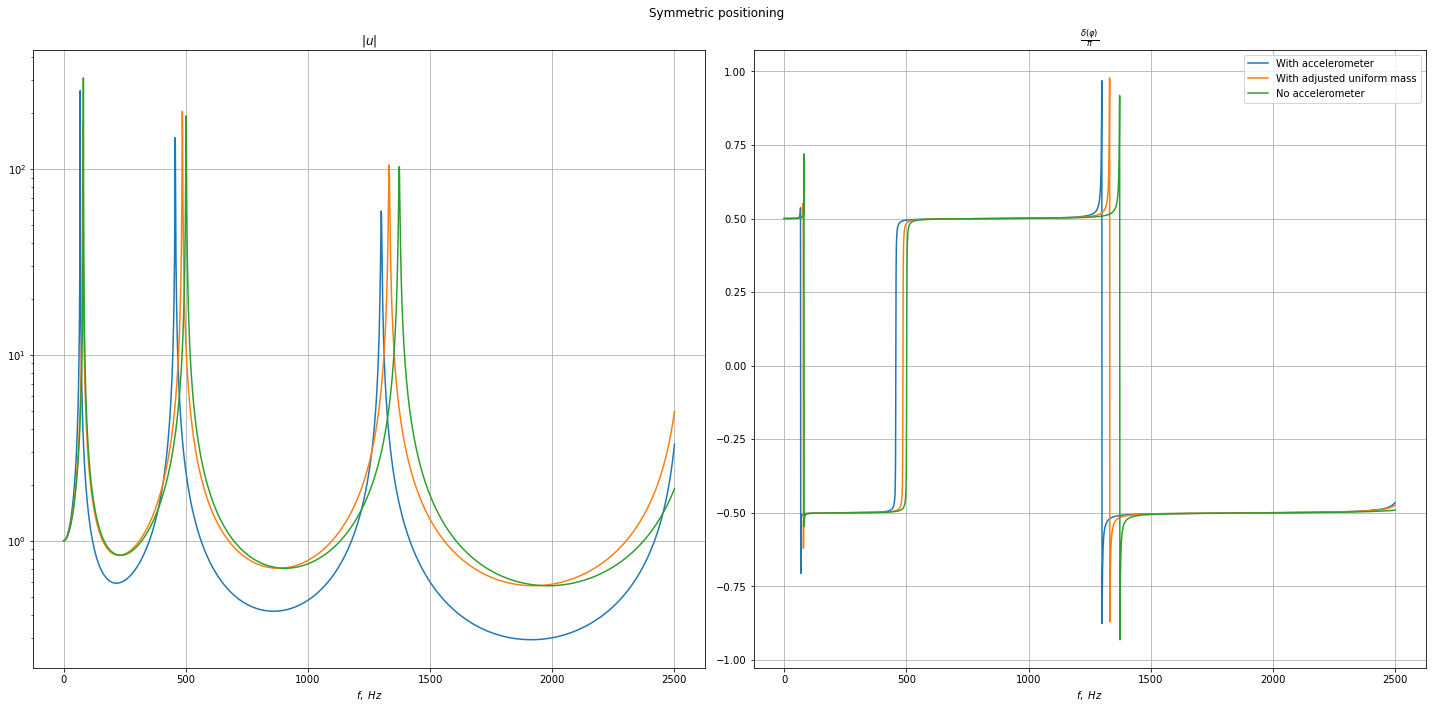

In [5]:
fig, axs = plot_afc(freqs, afc_w_accel, label='With accelerometer')
fig, axs = plot_afc(freqs, afc_rho_adjusted, label='With adjusted uniform mass', fig=fig)
fig, axs = plot_afc(freqs, afc_no_accel, label="No accelerometer", fig=fig)
fig.suptitle('Symmetric positioning')
fig.tight_layout()

One can clearly see that introducing the accelerometer mass significantly changes the AFC, and this effect cannot be reproduced by just adjusting the total mass of the specimen.

## Comparing setups with symetric and shifted accelerometer

In [6]:
p_sym = Problem("_strip.edp", h, rho, accelerometer_params)
p_shift = Problem("_strip_shifted.edp", h, rho, accelerometer_params)

freqs = jnp.linspace(0, 2500, 2501, endpoint=True)

problems = [p_sym, p_shift]
labels = ['Symmetric', 'Shifted']
afcs = [p.getAFCFunction(isotropic_to_full, batch_size=bs)(freqs, params) for p in problems]

The code below evaluates natural frequencies and decay factors, i.e. numbers $\omega_k, \gamma_k$ such that the solution of a problem without loading can be represented as a series of decaying vibrations
$$
    u(x, y, t) = \sum_{k=1}^{\infty}e^{(-\gamma_k + i\omega_k)t}u_k(x,y)
$$

When the parameters are frequency independent, these values can be found as the solution of the eigenvalue problem below. Peaks in the AFC lie in proximity of the natural frequencies.

In [7]:
import scipy.linalg
nfs = []
for p in [p_sym, p_shift]:
    K_real, K_imag, M = p.getSolutionMatrices(*isotropic_to_full(params))
    A = K_real + 1j*K_imag
    B = M
    eigvals, eigvects = scipy.linalg.eig(A, b=B)
    lams = jnp.sqrt(eigvals)
    argsorted = jnp.argsort(jnp.abs(lams.real))[:5]
    natural_exps = lams[argsorted]*1j

    natural_freqs = natural_exps.imag/2./jnp.pi
    nfs.append(natural_freqs)
    loss_factors = natural_exps.real
nfs

[DeviceArray([  67.86416569,  457.0405379 ,  792.85446258, 1300.19259436,
              2408.95420423], dtype=float64),
 DeviceArray([  67.58088297,  453.10647158,  753.95381545, 1308.39195911,
              2294.60245012], dtype=float64)]

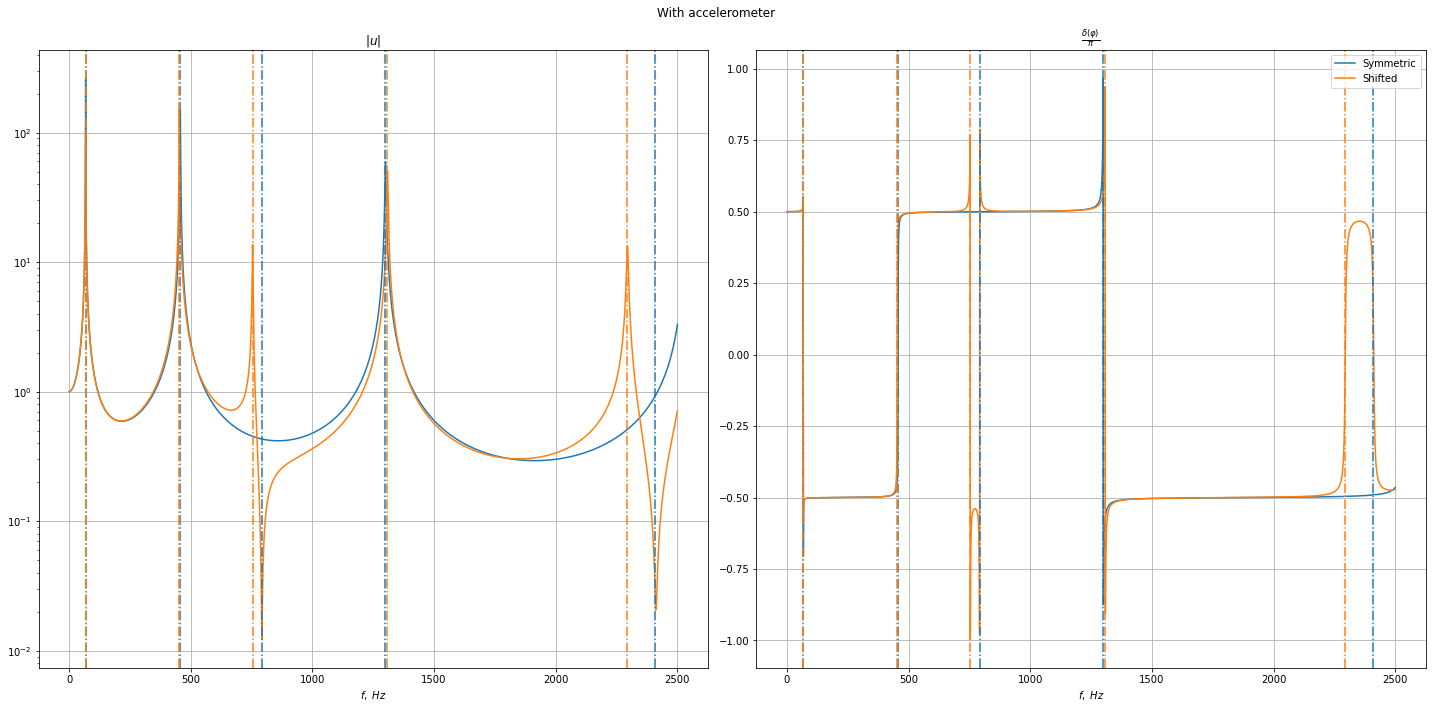

In [8]:
fig = None
for i, afc in enumerate(afcs):
    fig, axs = plot_afc(freqs, afc, fig=fig, label=labels[i])

ys = [0.9, 0.9, 0.5, 0.6, 0.6]
ys = [1.]*5  
    
for idx, nf in enumerate(nfs):
    color = f"C{idx:d}"
    linestyle = '-.'
    for jdx, f in enumerate(nf):
        for ax in axs:
            ax.axvline(f, color=color, linestyle=linestyle, ymax=ys[jdx])
    
fig.suptitle('With accelerometer')
fig.tight_layout()

It can be seen that for the configuration with shifted accelerometer, there are additional peaks in the AFC near 3-d and 5-th natural frequency, an effect that couldn't have been captured with a beam model. 

## Example of local minimization

In [25]:
start_params = params*(jnp.array([0.2, 0.05, 99.]) + 1.)
ref_params = params
with np.printoptions(formatter={'float': lambda x: f'{x:.1e}'}):
    print('RE before local optimization', (start_params - ref_params)/ref_params)

RE before local optimization [2.0e-01 5.0e-02 9.9e+01]


In [26]:
p = Problem("_strip_shifted.edp", h, rho, accelerometer_params)
getAFC = p.getAFCFunction(isotropic_to_full)

freqs = jnp.linspace(0, 600, 201, endpoint=True)
ref_afc = getAFC(freqs, ref_params)
start_afc = getAFC(freqs, start_params)

In [27]:
from time import perf_counter

loss_function = p.getMSELossFunction(isotropic_to_full, freqs, ref_afc)

t = perf_counter()
opt_result = optimize_trust_region(loss_function, jnp.array(start_params), N_steps=250, delta_max=0.1, eta=0.15)
dt = perf_counter() - t

print('Elapsed time,', dt, 's')

with np.printoptions(formatter={'float': lambda x: f'{x:.1e}'}):
    print('RE after optimization (MSE)', (opt_result.x - ref_params)/ref_params)

Elapsed time, 591.377759895986 s
RE after optimization (MSE) [4.1e-10 2.6e-09 7.2e-11]


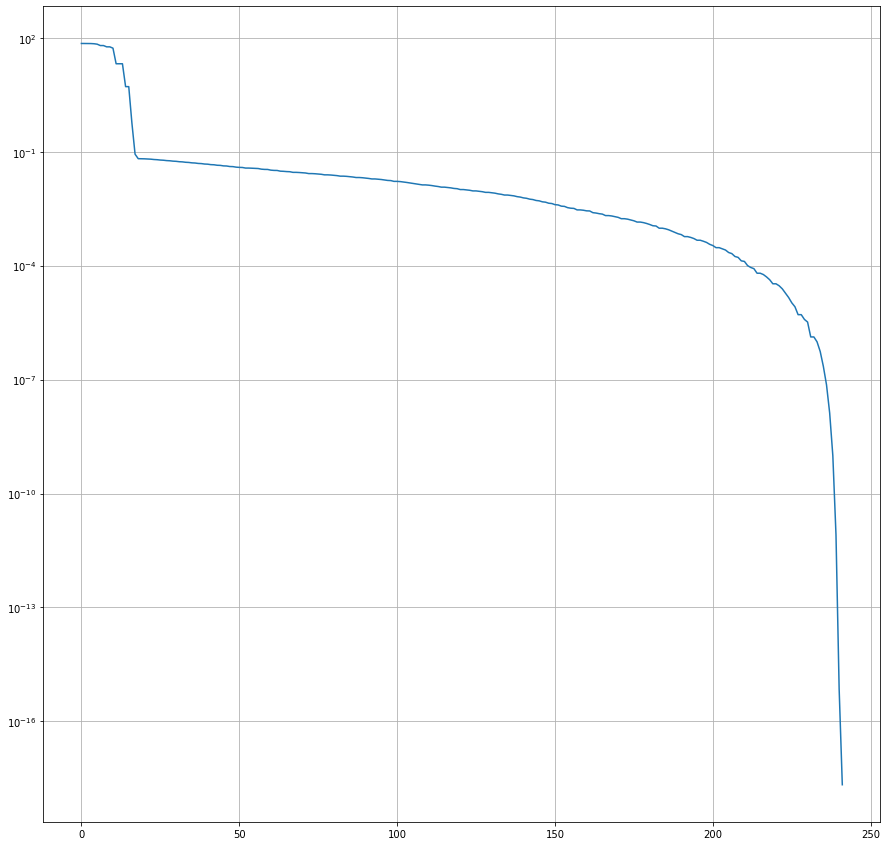

In [29]:
fig, axs = plt.subplots(1,1, figsize=(15,15))
axs.plot(opt_result.f_history[:])
axs.set_yscale('log')
axs.grid(True)

(<Figure size 1440x720 with 2 Axes>,
 [<AxesSubplot:title={'center':'$\\|u\\|$'}, xlabel='$f,\\ Hz$'>,
  <AxesSubplot:title={'center':'$\\frac{\\delta(\\varphi)}{\\pi}$'}, xlabel='$f,\\ Hz$'>])

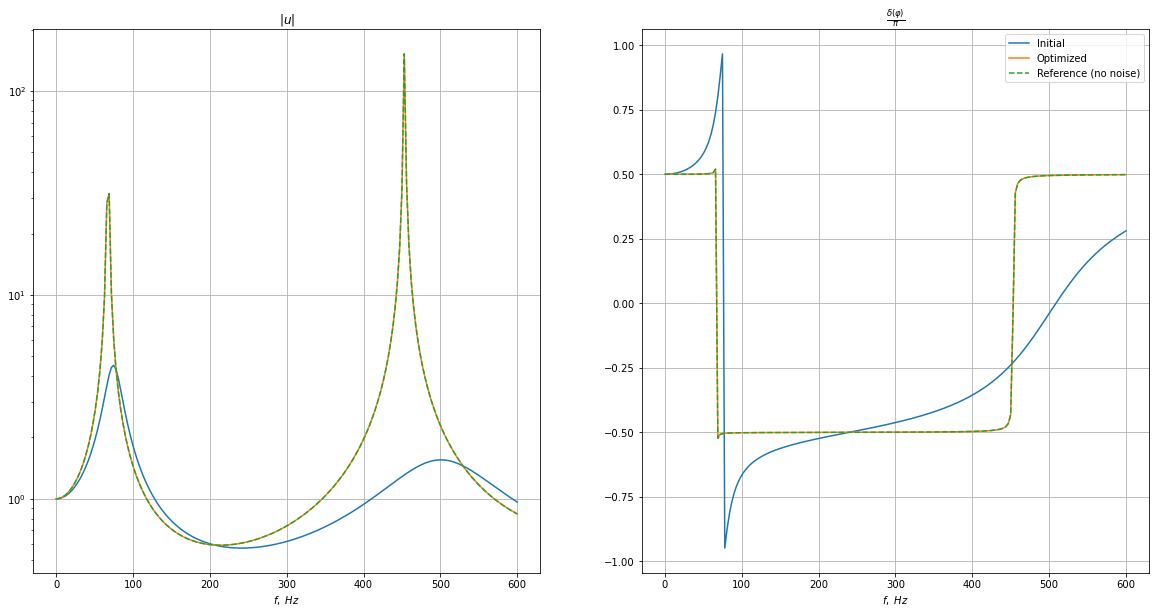

In [30]:
optimized_afc = getAFC(freqs, opt_result.x)
fig, axs = plot_afc(freqs, start_afc, label='Initial')
plot_afc(freqs, optimized_afc, label='Optimized', fig=fig)
plot_afc(freqs, ref_afc, label='Reference (no noise)', linestyle='--', fig=fig)
